In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
plt.style.use('../../../paper_1/figures/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [4]:
lgMh_s0_mat = np.load("../../../data/MW-analog/meta_data_psi3/models.npz")["mass"]

lgMh_s15_mat = np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"]

lgMh_s30_mat = np.load("../../../data/cross_host/lognorm_030_psi3/models.npz")["mass"]

In [5]:
def covariance(mass_2D, min, max, Nbins):

    mass_bins = np.linspace(min, max, Nbins)
    N_ij = np.apply_along_axis(jsm_stats.count, 1, mass_2D, mass_bins) 
    C_ij = np.cov(N_ij.T)
    # numerator = np.sum([np.sum(np.diagonal(C_ij, offset=i)) for i in range(1, Nbins)]) # this iterates over the offsets of the diagonal and sums everything!
    # denominator = C_ij.trace()
    # Qstat = numerator/denominator
    return C_ij, mass_bins

In [6]:
C_s0, mass_bins = covariance(np.vstack(lgMh_s0_mat), 9.5, 12.5, Nbins=31)

C_s15, _ = covariance(np.vstack(lgMh_s15_mat), 9.5, 12.5, Nbins=31)

C_s30, _ = covariance(np.vstack(lgMh_s30_mat), 9.5, 12.5, Nbins=31)

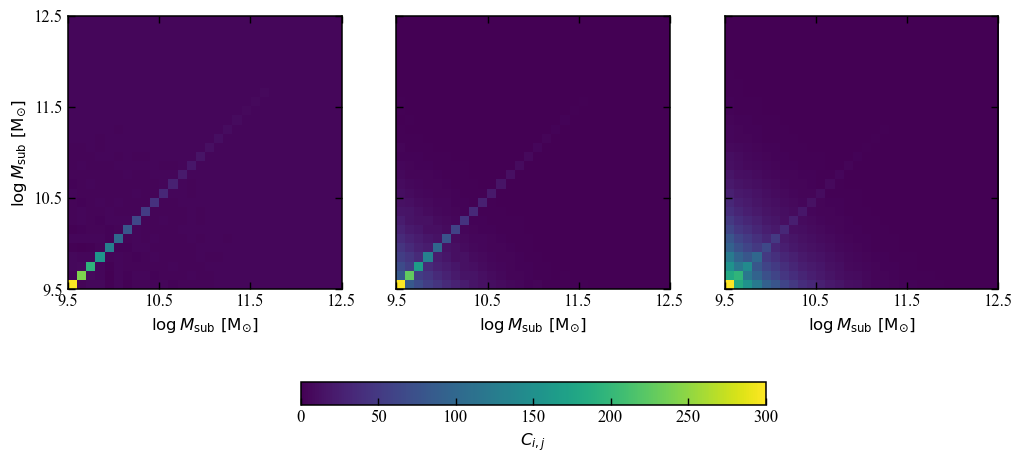

In [7]:
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 300)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(C_s0, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[1].imshow(C_s15, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[2].imshow(C_s30, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([9.5, 10.5, 11.5, 12.5]) 
axs[0].set_yticks([9.5, 10.5, 11.5, 12.5]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$C_{i,j}$")
plt.show()

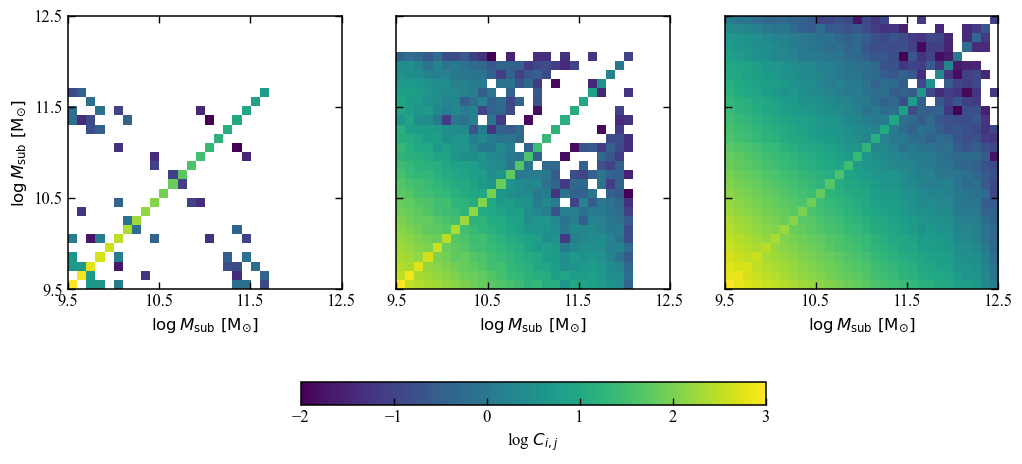

In [8]:
cmap = cm.get_cmap('viridis')
normalizer = Normalize(-2, 3)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(np.log10(C_s0), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[1].imshow(np.log10(C_s15), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[2].imshow(np.log10(C_s30), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([9.5, 10.5, 11.5, 12.5]) 
axs[0].set_yticks([9.5, 10.5, 11.5, 12.5]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("log $C_{i,j}$")
plt.show()

#### the covariance in the stacked SMF

In [9]:
min_mass = 6.5
Nbins = 31
mass_bins = np.linspace(min_mass, 12.5, Nbins)

In [10]:
def NADLER_cov(lgMh_mat, theta=[10.5, 2.0, 0.0, 0.0, 0.2, 0.0]):

    lgMs_mat = np.apply_along_axis(jsm_SHMR.general_new, 0, theta, lgMh_mat, 0.0, 1.0)
    N_ij = np.zeros(shape=(lgMh_mat.shape[0], Nbins-1))

    for ind, realization in enumerate(lgMs_mat):
        stat_i = jsm_stats.SatStats_D_NADLER(realization, min_mass, Nbins)
        stat_help = jsm_stats.SatStats_D(realization, min_mass, max_N=400)
        N_ij[ind] = stat_i.stack
    C_ij = np.cov(N_ij.T)
    return C_ij, N_ij, stat_help

In [11]:
C_s0_stacked, test_0, hmm_0 = NADLER_cov(lgMh_s0_mat)

C_s15_stacked, test_15, hmm_15 = NADLER_cov(lgMh_s15_mat)

C_s30_stacked, test_30, hmm_30 = NADLER_cov(lgMh_s30_mat)

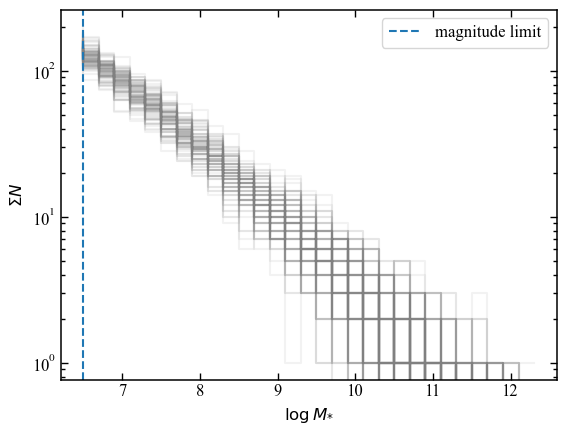

In [12]:
for i in test_30:
    plt.step(mass_bins[:-1], i, color="grey", alpha=0.1)
total = np.sort(hmm_30.mass_rank.flatten())[~np.isnan(np.sort(hmm_30.mass_rank.flatten()))]
#plt.step(total, np.arange(0, total.shape[0])[::-1], color="k", where="mid")
plt.axvline(6.5, ls="--", label="magnitude limit")
plt.xlabel("$\log M_{*}$")
plt.ylabel("$\Sigma N$")
plt.legend()
plt.yscale("log")
plt.show()

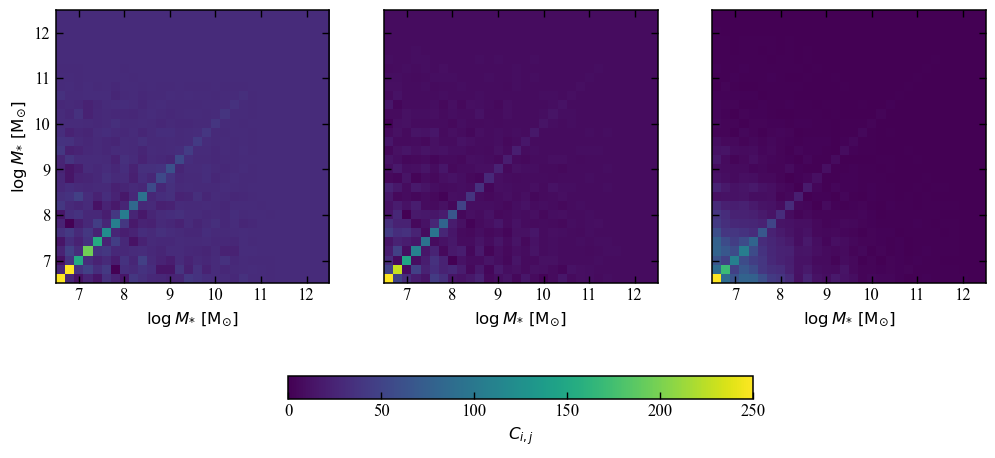

In [13]:
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 250)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(C_s0_stacked, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[1].imshow(C_s15_stacked, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[2].imshow(C_s30_stacked, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([7, 8, 9, 10, 11, 12]) 
axs[0].set_yticks([7, 8, 9, 10, 11, 12]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$C_{i,j}$")
plt.show()

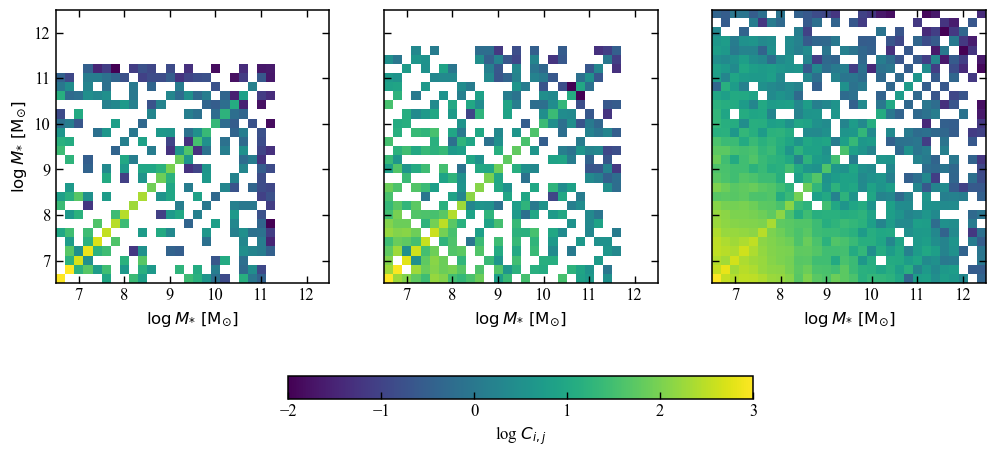

In [14]:
cmap = cm.get_cmap('viridis')
normalizer = Normalize(-2, 3)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(np.log10(C_s0_stacked), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[1].imshow(np.log10(C_s15_stacked), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")
axs[2].imshow(np.log10(C_s30_stacked), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap="viridis", origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([7, 8, 9, 10, 11, 12]) 
axs[0].set_yticks([7, 8, 9, 10, 11, 12]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("log $C_{i,j}$")
plt.show()